# Reducción de ruido en imágenes

El ruido se introduce en imágenes debido a la variación de la luz, fluctuación de la temperatura, la calidad de la cámara y sensores, e incluso por cómo es almacenada la imagen.

Existen muchas categorizaciones de ruido (https://en.wikipedia.org/wiki/Image_noise). En este notebook, nos enfocaremos en remover ruido gaussiano de imágenes, el cual es un modelo razonable al tomar en cuenta el funcionamiento de los sensores CCD y CMOS, y la naturaleza (cuántica) de los fotones.

Este notebook implementa el algoritmo del paper "Two-stage image denoising by principal component analysis with local pixel grouping" de 2010:
- PCA se utiliza para la reducción de ruido
- LPG se utiliza para proteger las estructuras locales de la imagen

## Ingredientes para el algoritmo

### Métricas

**PSNR(Peak Signal-to-Noise Ratio)**

Razón entre el valor máximo de una señal y el poder de ruido.

Se define (en decibeles) como:

$$
\text{PSNR} = 10 \cdot \log_{10} \left( \frac{\text{MAX}^2}{\text{MSE}} \right)
$$

Donde MSE es el error cuadratico medio entre la imagen inicial monocromática y una aproximación ruidosa.

**SSIM (Structural Similarity)**

Compara iluminación, contraste y estructura entre imágenes (https://en.wikipedia.org/wiki/Structural_similarity_index_measure). Compara medias y covarianzas entre (ventanas de) imágenes.

$$
SSIM(x, y) = \frac{(2\mu_x\mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}
$$

Donde 1 indica similitud perfecta, 0 indica que no hay similitud y -1 indica anticorrelación perfecta.

In [ ]:
!pip3 install scikit-image

In [1]:
import skimage

In [ ]:
skimage.__version__

'0.24.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from skimage.metrics import structural_similarity as ssim    
from skimage.metrics import peak_signal_noise_ratio as psnr

### Funciones auxiliares

In [58]:
# Función utilizada para 'inflar' imágenes (esto le ayuda a LPG)
def blow_gray(B):
    [n, m] = B.shape
    n = 2 * n
    m = 2 * m
    A = np.zeros((n,m))

    A[0:n:2, 0:m:2] = B
    A[0:n:2, 1:m:2] = B
    A[1:n:2, 0:m:2] = B
    A[1:n:2, 1:m:2] = B

    return A

def blow_color(B):
    [n, m, ch] = B.shape
    n = 2 * n
    m = 2 * m
    A = np.zeros((n,m,ch))

    A[0:n:2, 0:m:2, :] = B
    A[0:n:2, 1:m:2, :] = B
    A[1:n:2, 0:m:2, :] = B
    A[1:n:2, 1:m:2, :] = B

    return A

### Principal Component Analysis (PCA)

Una imágen es esencialmente una matriz, por lo que podemos aplicarle técnicas de álgebra lineal.

Los pasos para realizar un PCA son:
- Calcular la media
- Centrar los datos
- Calcular la matriz de covarianza y obtener sus valores propios. Ordernarlos de forma ascendente.
- Proyectar en el nuevo espacio ($Y = PX$, donde $P$ es la nueva base).

In [37]:
X = np.array([[0, 2, 0, 0],
              [121, 120, 120, 120],
              [255, 254, 255, 255]])

[m, n] = X.shape

mu_x = (np.mean(X, axis=1))
mu_x = mu_x.reshape((m, 1))
mu_x

array([[  0.5 ],
       [120.25],
       [254.75]])

In [38]:
X = X - mu_x
X

array([[-0.5 ,  1.5 , -0.5 , -0.5 ],
       [ 0.75, -0.25, -0.25, -0.25],
       [ 0.25, -0.75,  0.25,  0.25]])

In [39]:
CovX = (X @ X.T) / (n-1)
CovX

array([[ 1.        , -0.16666667, -0.5       ],
       [-0.16666667,  0.25      ,  0.08333333],
       [-0.5       ,  0.08333333,  0.25      ]])

In [40]:
[V, P]= np.linalg.eig(CovX)
V

array([ 1.28359369, -0.        ,  0.21640631])

In [41]:
def getpca(X):
    # X: matriz mxn
    # Y: Y=P*X
    # P: matriz de transformación
    # V: lista de eigenvalores

    [m, n] = X.shape

    mu_x = (np.mean(X, axis=1))
    mu_x = mu_x.reshape((m, 1))

    X = X - mu_x

    CovX = (X @ X.T) / (n-1)
    [V, P]= np.linalg.eig(CovX) # V son los eigenvalores, P, los eigenvectores

    V_minus = -1 * V
    ind = np.argsort(V_minus)
    V = V[ind]

    P = P[:, ind]

    P = P.T
    Y = np.matmul(P, X)

    return [Y, P, V, mu_x]

In [59]:
def dim_reduction(X):
    # Obtenemos el número de filas
    n = X.shape[0]
    # Calcula el número de componentes principales a usar (40% de n)
    n = math.floor(n * 0.4)
    # Llamamos getpca
    [coe, P, V, mX] = getpca(X)
    # Proyectamos los datos originales X en el espacio reducidp. 
    Y = P[0 : n, :] @ X
    return Y

### Local Pixel Grouping (LPG)

La suposición es que la energía de la señal (imagen capturada) se concentrará en un subconjunto del dataset transformado vía PCA. Mientras tanto, el ruido se distribuirá uniformemente a través del dataset transformado vía PCA

(https://en.wikipedia.org/wiki/Local_pixel_grouping)

Tenemos que encontrar un dataset auxiliar, $X_v$, el cuál tendrá a la señal "protegida". Después podremos reducirle el ruido a $X_v$ vía PCA.

Los pasos para realizar un LPG son:
- Definir la ventana de entrenamiento (la grande)
- Definir la ventana variable (la chica)
- Para cada ventana variable posible, tome todos sus pixeles. Esto es una muestra (o un vector).
- Si la distancia entre cada muestra y el centro de ventana es menor que un umbral, aceptar la muestra

In [63]:
def LPG_new(X, row, col, off, nv, S, I):
    """Local Pixel Grouping

    X: Imagen

    row y col: centro de la ventana de entrenamiento
    S: (Mitad del) tamaño de la ventana de entrenamiento

    off: Indica la posicion del vector del centro
    nv: Número mínimo de vectores a regresar
    
    I: Matriz para recuperar los vectores de la ventana de entrenamiento
    """

    [n, m] = I.shape
    f2 = X.shape[1]

    # Ventana de entrenamiento
    rmin = max(row - S, 0)
    rmax = min(row + S + 1, n)
    cmin = max(col - S, 0)
    cmax = min(col + S + 1, m)

    # Índices de los vectores de la ventana de entrenamiento
    idx = I[rmin: rmax, cmin: cmax]
    idx = (idx.T).flatten()

    # Vectores dentro de la ventana de entrenamiento
    B = X[idx,:]

    # Vector del centro
    v = X[off,:]

    # Calculamos la distancia (euclideana) de cada muestra respecto al vector del centro
    dis = ( (B[:, 0] - v[0])**2 )
    dis = dis.reshape((dis.shape[0], 1))

    for k in range(1, f2):
        dis_partial = ((B[:, k] - v[k])**2)
        dis_partial = dis_partial.reshape((dis_partial.shape[0], 1))
        dis = dis + dis_partial

    dis = dis/f2
    
    # Se ordenan de menor a mayor
    ind = np.argsort(dis, axis=0)
    # Se regresan los índices de los nv vectores con menor distancia
    indc = idx[ind[0:nv]]

    return indc

## Algoritmo de denoising de dos fases

<img src='./imgs/pipeline.png'/>

(PCA): $Y = PX$

(PCA inverso): $X = P^TY + \mu _X$

**Limitaciones del algoritmo:**
- Se pide como entrada un nivel estimado de ruido
- La computación es bastante intensiva

**Entradas del algoritmo:**
- noise_img: Imagen con ruido.
- orig_img: Imagen original (sin ruido).
- std: Desviación estándar del ruido.
- profile: Modo de procesamiento ('fast' o 'normal').
- K: Parámetro para recortar los bordes de la imagen.

**Algoritmo:**

- Inicialización: Determina el tamaño de los bloques de píxeles que se utilizarán para el procesamiento basado en el perfil y las dimensiones de las imágenes.

- Local Pixel Grouping: Se generan bloques de píxeles de la imagen ruidosa para su posterior análisis. Estos bloques son arreglos de píxeles que se consideran "vecinos" y se utilizan para estimar el valor del píxel central.

- Reducción de Dimensionalidad: Dependiendo del perfil, se puede reducir la dimensionalidad de los bloques utilizando PCA para facilitar el procesamiento.

- Denoising: Para cada posible píxel central, se identifican los bloques más cercanos utilizando la función LPG_new, que agrupa píxeles similares. Se aplica PCA a estos bloques para encontrar componentes principales. Se reconstruye la imagen filtrada (dI) a partir de los bloques procesados.

- Normalización: La imagen resultante se normaliza para evitar valores fuera del rango de intensidad aceptable.

- Refinamiento: Se repite el proceso de eliminación de ruido para refinar aún más la imagen.


In [ ]:
def LPGPCA_denoising(noise_img, orig_img, std, profile, K):
    if profile == 'fast':
        s = 2
    elif profile == 'normal':
        s = 1

    [n, m] = orig_img.shape
    [h, w] = noise_img.shape

    #-----------------------------------------------------------------
    # Fase I: denoising
    #-----------------------------------------------------------------

    # Varianza
    v2 = std**2

    # Ventana de entrenamiento (2k + 1) * (2k + 1)
    S = 20

    # Ventana variable (2t + 1) * (2t + 1)
    t = 3
    b = 2 * t + 1
    b2 = b * b

    # Número mínimo de muestras a recuperar para cada pixel central
    nblk = 250

    k = 0

    # Número de filas que tienen pixeles a eliminar ruido
    N = h - b + 1
    # Número de columnas que tienen pixeles a eliminar ruido
    M = w - b + 1

    # Cantidad de pixeles que pueden ser centro de "variable block"
    L = N * M

    # Si última entrada de r es menor a N-1, rellenar
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, 
                       np.arange(r[-1], N)))
        
    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c,
                       np.arange(c[-1], M)))

    # Matriz para alojar todos los posibles bloques
    X = np.zeros((b*b, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), 
                            j : (w - b + j + 1)]
            blk = (blk.T).flatten()
            X[k, :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    # Matriz auxiliar de índices
    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2, L))

    # Para cada pixel a quitar ruido (centro del variable block)
    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            # Se obtienen los índices de los nblk-th vectores más cercanos
            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()

            # PCA sobre los vectores más cercanos al pixel a quitar ruido
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            # Se transforma a vector columna
            py = py.reshape((py.shape[0], 1))
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]


    # Fin: El output es la imagen procesada
    dI = np.zeros((h, w))
    im_wei = np.zeros((h, w))
    k = 0
    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv] = dI[rv, cv] + (Y[k, :].T).reshape((N1, M1))
            im_wei[rv, cv] = im_wei[rv, cv] + 1
            k = k + 1

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))
    print("imwei.max: ", np.max(im_wei))
    print("imwei.min: ", np.min(im_wei))

    eps = 1e-23
    dI = dI/(im_wei + eps)

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))

    psnr_1 = 0
    ssim_1 = 0

    plt.imshow(dI, cmap='gray')
    plt.title('primer paso procesamiento')
    plt.show()

    row, col = orig_img.shape
    orig_img_crop = orig_img.astype(dtype=int)
    dI_crop = dI.astype(dtype=int)
    psnr_1 = psnr(orig_img_crop, dI_crop)
    ssim_1 = ssim(orig_img_crop, dI_crop)

    dif = dI[(K) : (n - K), (K) : (m - K)] - noise_img[(K) : (n - K), (K) : (m - K)]
    print ("mean diff: ", np.mean(dif**2))
    vd = std**2 - np.mean(dif**2)
    v1 = math.sqrt(abs(vd))
    print ("v1: ", v1)

    
    #-----------------------------------------------------------------
    # Fase 2: refinement
    #-----------------------------------------------------------------

    psnr_2 = 0
    ssim_2 = 0

    noise_img = dI
    v = v1 * 0.36
    v2 = v**2

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1)]
            blk = (blk.T).flatten()
            X[k, :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]


    # Output the processed image
    dI = np.zeros((h, w))
    im_wei = np.zeros((h, w))
    k = 0

    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv] = dI[rv, cv] + (Y[k, :].T).reshape((N1, M1))
            im_wei[rv, cv] = im_wei[rv, cv] + 1
            k = k + 1

    eps = 1e-23
    dI = dI/(im_wei + eps)

    row, col = orig_img.shape

    print("dI2.max: ", np.max(dI))
    print("dI2.min: ", np.min(dI))

    orig_img_crop = orig_img.astype(dtype=int)
    dI_crop = dI.astype(dtype=int)

    # Comparaciones
    psnr_2 = psnr(orig_img_crop, dI_crop)
    ssim_2 = ssim(orig_img_crop, dI_crop)

    plt.imshow(dI, cmap='gray')
    plt.title('Output de imagen procesada')
    plt.show()

    d_im = dI[K:n-K, K:m-K]

    return [d_im, psnr_1, ssim_1, psnr_2, ssim_2]

## Ejemplo 1: Imágenes blanco y negro

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Imagen para pruebas
img_filename = './cameraman.tif'
img_prueba = plt.imread(img_filename).astype(dtype=float)

In [5]:
img_prueba

array([[156., 159., 158., ..., 151., 152., 152.],
       [160., 154., 157., ..., 154., 155., 153.],
       [156., 159., 158., ..., 151., 152., 152.],
       ...,
       [114., 132., 123., ..., 135., 137., 114.],
       [121., 126., 130., ..., 133., 130., 113.],
       [121., 126., 130., ..., 133., 130., 113.]])

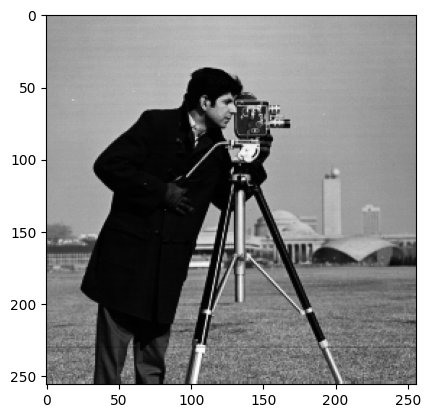

In [6]:
plt.imshow(img_prueba, cmap='gray')
plt.show()

orig_img.shape:  (256, 256)
orig_img.max:  253.0
orig_img.min:  7.0


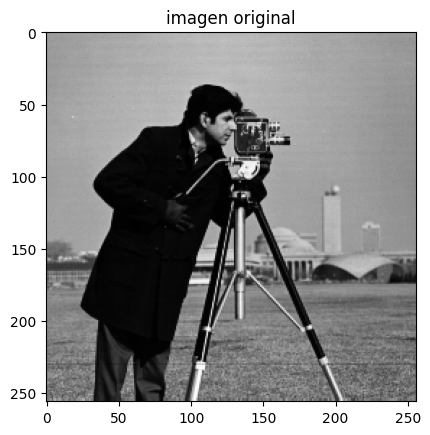

noise_img.shape:  (256, 256)
noise_img.max:  303.9891323857109
noise_img.min:  -63.64065270537809


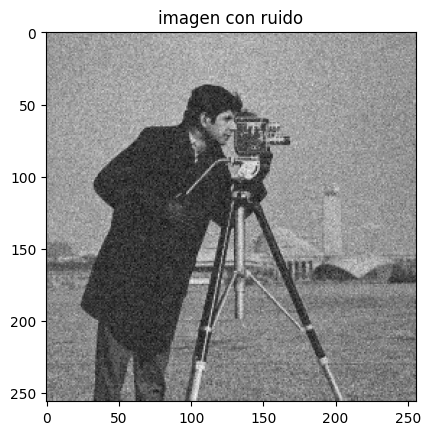

dI.max:  13237.756727631298
dI.min:  -1181.1045701323328
imwei.max:  49.0
imwei.min:  1.0
dI.max:  275.42505676155724
dI.min:  -24.104174900659853


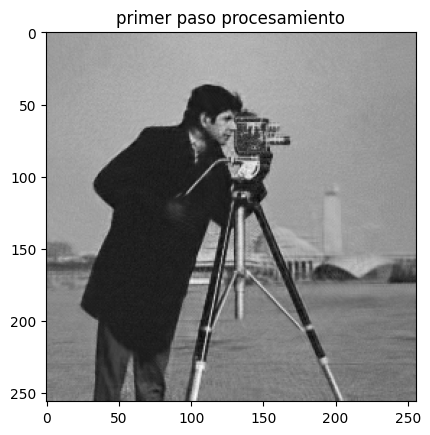

mean diff:  282.29072041845063
v1:  10.849390747021205


/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_1001/2459255871.py:134: UserWarning: Setting data_range based on im1.dtype. data_range = 18446744073709551616. Please specify data_range explicitly to avoid mistakes.
  ssim_1 = ssim(orig_img_crop, dI_crop)


dI2.max:  270.69808760346706
dI2.min:  -21.81526463362396


/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_1001/2459255871.py:236: UserWarning: Setting data_range based on im1.dtype. data_range = 18446744073709551616. Please specify data_range explicitly to avoid mistakes.
  ssim_2 = ssim(orig_img_crop, dI_crop)


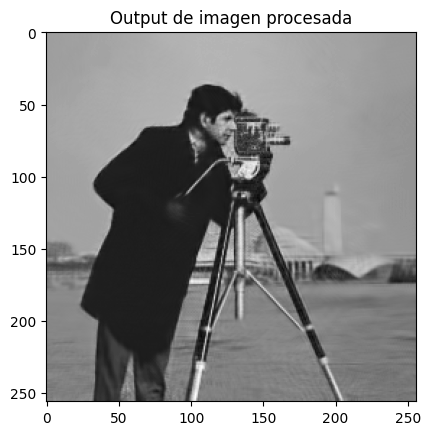

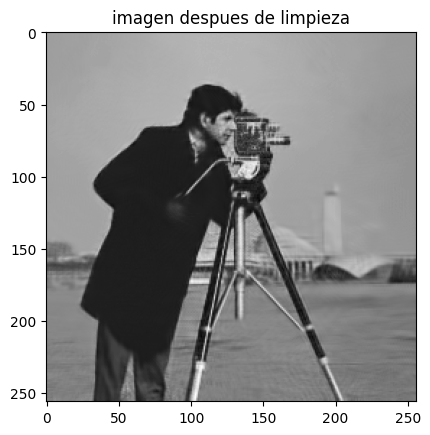

psnr1:  360.6535974525459
ssim1:  1.0
psnr2:  360.85510650466284
ssim2:  1.0


In [ ]:
profile = 'normal'
std = 20
img_filename = './cameraman.tif'
orig_img = plt.imread(img_filename).astype(dtype=float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img, cmap='gray')
plt.title('imagen original')
plt.show()

seed = 0
random.seed(seed)

noise = np.random.normal(size=(orig_img.shape))
noise = noise/np.sqrt(np.mean(noise**2))
noise_img = orig_img + (std * noise)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img, cmap='gray')
plt.title('imagen con ruido')
plt.show()

#El ancho de los límites excluidos
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] = LPGPCA_denoising(noise_img, orig_img, std, profile, bound_exclude_width)

plt.imshow(denoise_img, cmap='gray')
plt.title('imagen despues de limpieza')
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)


- **dI.max/min:** Indican los valores extremos de intensidad acumulados y normalizados en la imagen denoised.
- **imwei.max/min:** Representan la cantidad de contribuciones de bloques a cada píxel, asegurando que cada píxel haya sido procesado al menos una vez.
- **mean diff:** Error cuadrático medio (Mean Squared Error, MSE) entre la imagen denoised (dI) y la imagen ruidosa original (noise_img).
- **v1:** Estimación refinada de la desviación estándar del ruido residual.

orig_img.shape:  (256, 256)
orig_img.max:  253.0
orig_img.min:  7.0


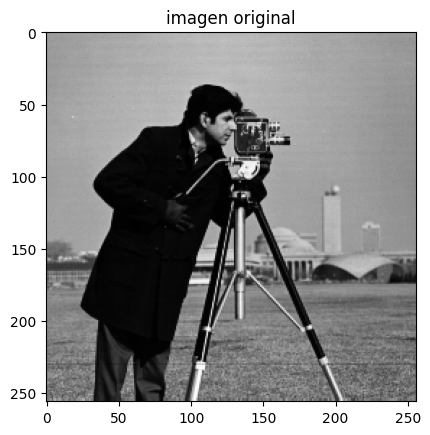

noise_img.shape:  (256, 256)
noise_img.max:  302.9408428023796
noise_img.min:  -57.772028761142906


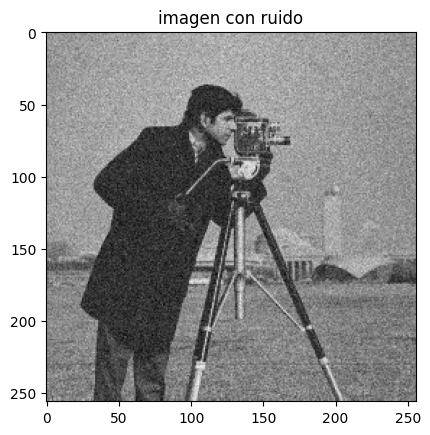

dI.max:  4182.6082589231055
dI.min:  -376.2631790422623
imwei.max:  16.0
imwei.min:  1.0
dI.max:  270.9958063286171
dI.min:  -26.286874900109158


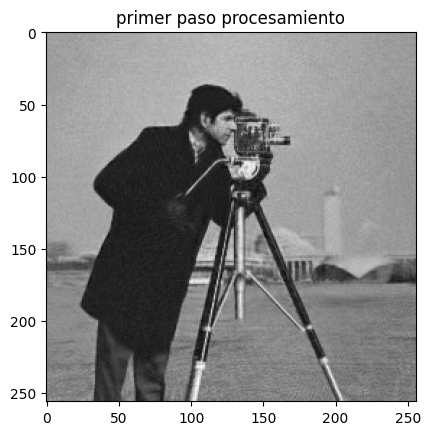

mean diff:  247.20555925695697
v1:  12.361004843581409


/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_7463/1380445116.py:137: UserWarning: Setting data_range based on im1.dtype. data_range = 18446744073709551616. Please specify data_range explicitly to avoid mistakes.
  ssim_1 = ssim(orig_img_crop, dI_crop)


dI2.max:  269.85643565278855
dI2.min:  -25.390713769629134


/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_7463/1380445116.py:239: UserWarning: Setting data_range based on im1.dtype. data_range = 18446744073709551616. Please specify data_range explicitly to avoid mistakes.
  ssim_2 = ssim(orig_img_crop, dI_crop)


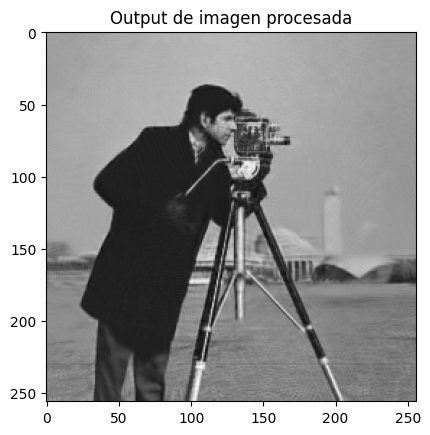

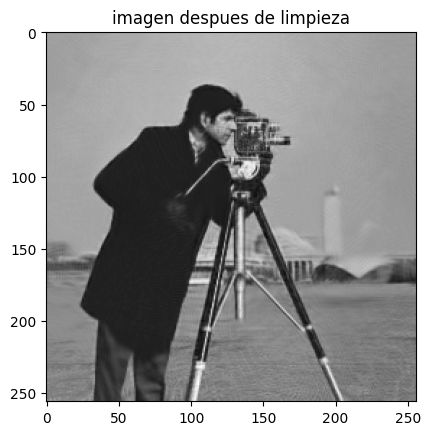

psnr1:  360.4427888593461
ssim1:  1.0
psnr2:  361.0567400734474
ssim2:  1.0


In [14]:
profile = 'fast'
std = 20
img_filename = './cameraman.tif'
orig_img = plt.imread(img_filename).astype(dtype=float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img, cmap='gray')
plt.title('imagen original')
plt.show()

seed = 0
random.seed(seed)

noise = np.random.normal(size=(orig_img.shape))
noise = noise/np.sqrt(np.mean(noise**2))
noise_img = orig_img + (std * noise)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img, cmap='gray')
plt.title('imagen con ruido')
plt.show()

#El ancho de los límites excluidos (lo dejamos en 0)
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_denoising(noise_img, orig_img, std, profile, bound_exclude_width);

plt.imshow(denoise_img, cmap='gray')
plt.title('imagen despues de limpieza')
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

## Ejemplo 2: Imágenes a color

In [24]:
import PIL
import urllib

orig_img.shape:  (481, 321, 3)
orig_img.max:  255
orig_img.min:  0


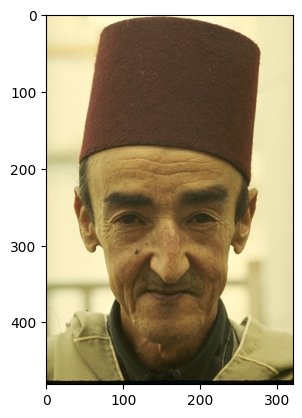

In [32]:
img_filename = './0038.png' #'0038.png'
orig_img = np.array(PIL.Image.open(img_filename))
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img)
plt.show()

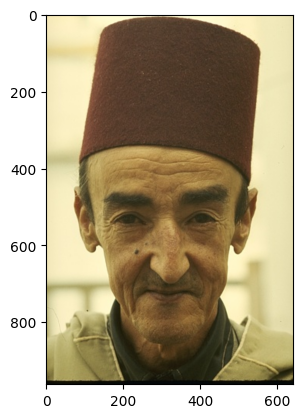

In [33]:
plt.imshow(blow_color(orig_img).astype(dtype=int))
plt.show()

In [34]:
orig_img.shape , blow_color(orig_img).shape

((481, 321, 3), (962, 642, 3))

In [35]:
from PIL import Image

In [37]:
def LPGPCA_color_denoising(noise_img, orig_img, std, profile):
    s = 4
    if profile == 'fast':
        s = 4
    elif profile == 'normal':
        s = 3

    [n, m, ch] = orig_img.shape
    [h, w, ch] = noise_img.shape

    ##############First stage denoising###############

    v2 = std**2
    # training block(2k + 1) * (2k + 1)
    S = 20
    # variable block(2t + 1) * (2t + 1)
    t = 3
    nblk = 250
    b = 2 * t + 1
    b2 = b * b

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b*ch, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 0]
            blk = (blk.T).flatten()
            X[k, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 1]
            blk = (blk.T).flatten()
            X[k + b2, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 2]
            blk = (blk.T).flatten()
            X[k + (2 * b2), :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2*ch, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]


    # Output the processed image
    dI = np.zeros((h, w, ch))
    im_wei = np.zeros((h, w, ch))
    k = 0
    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv, 0] = dI[rv, cv, 0] + (Y[k, :]).reshape((M1, N1))
            im_wei[rv, cv, 0] = im_wei[rv, cv, 0] + 1
            dI[rv, cv, 1] = dI[rv, cv, 1] + (Y[(k+b2), :]).reshape((M1, N1))
            im_wei[rv, cv, 1] = im_wei[rv, cv, 1] + 1
            dI[rv, cv, 2] = dI[rv, cv, 2] + (Y[k+(2*b2), :]).reshape((M1, N1))
            im_wei[rv, cv, 2] = im_wei[rv, cv, 2] + 1
            k = k + 1

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))
    print("imwei.max: ", np.max(im_wei))
    print("imwei.min: ", np.min(im_wei))

    eps = 1e-23
    dI = dI/(im_wei + eps)

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))

    dI = np.clip(dI, a_min=0, a_max=255)

    plt.imshow(dI/np.max(dI).astype(dtype=float))
    plt.show()

    dif_1 = dI[0 : n, 0 : m, 0] - noise_img[0 : n, 0 : m, 0]
    dif_2 = dI[0 : n, 0 : m, 1] - noise_img[0 : n, 0 : m, 1]
    dif_3 = dI[0 : n, 0 : m, 2] - noise_img[0 : n, 0 : m, 2]
    vd_1 = std**2 - np.mean(dif_1**2)
    vd_2 = std**2 - np.mean(dif_2**2)
    vd_3 = std**2 - np.mean(dif_3**2)
    vd  = (vd_1 + vd_2 + vd_3)/3
    v1 = math.sqrt(abs(vd))
    print ("v1: ", v1)

    #
    #-----------------------------------------------------------------
    # The second stage: refinement
    #-----------------------------------------------------------------

    psnr_2 = 0
    ssim_2 = 0

    noise_img = dI
    v = v1 * 0.37
    v2 = v**2

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b*ch, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 0]
            blk = (blk.T).flatten()
            X[k, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 1]
            blk = (blk.T).flatten()
            X[k + b2, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 2]
            blk = (blk.T).flatten()
            X[k + (2 * b2), :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2 * ch, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            # px = max(0, py - v2)
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]

    # Output the processed image
    dI = np.zeros((h, w, ch))
    im_wei = np.zeros((h, w, ch))
    k = 0

    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv, 0] = dI[rv, cv, 0] + (Y[k, :]).reshape((M1, N1))
            im_wei[rv, cv, 0] = im_wei[rv, cv, 0] + 1
            dI[rv, cv, 1] = dI[rv, cv, 1] + (Y[(k+b2), :]).reshape((M1, N1))
            im_wei[rv, cv, 1] = im_wei[rv, cv, 1] + 1
            dI[rv, cv, 2] = dI[rv, cv, 2] + (Y[(k+2*b2), :]).reshape((M1, N1))
            im_wei[rv, cv, 2] = im_wei[rv, cv, 2] + 1
            k = k + 1

    eps = 1e-23
    dI = dI/(im_wei + eps)

    dI = np.clip(dI, a_min=0, a_max=255)

    print("dI2.max: ", np.max(dI))
    print("dI2.min: ", np.min(dI))

    plt.imshow(dI/np.max(dI).astype(dtype=float))
    plt.show()

    d_im = dI[:n, :m, :]

    return d_im

orig_img.shape:  (481, 321, 3)
orig_img.max:  255
orig_img.min:  0


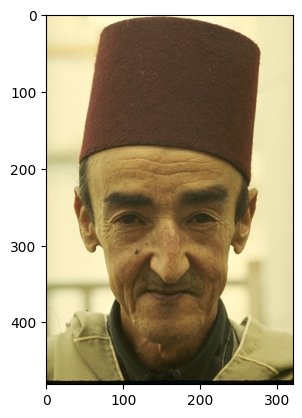

noise_img.shape:  (481, 321, 3)
noise_img.max:  255
noise_img.min:  0


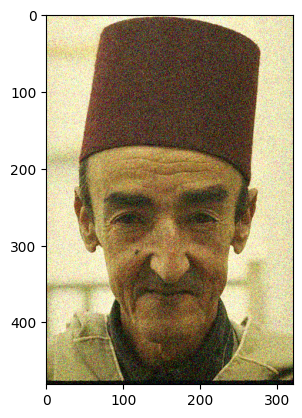

dI.max:  2853.5278999483903
dI.min:  -15.768042915997299
imwei.max:  12.0
imwei.min:  1.0
dI.max:  263.1355418415343
dI.min:  -3.9420107289993247


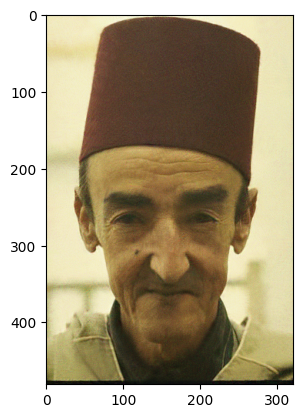

v1:  15.987870906080381
dI2.max:  255.0
dI2.min:  0.0


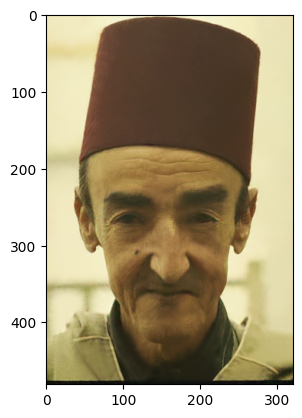

In [ ]:
profile = 'normal'
std = 25
img_filename = './0038.png'
orig_img = np.array(PIL.Image.open(img_filename))
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img)
plt.show()

seed = 0
random.seed(seed)

img_filename2 = './0038.png'
noise_img = np.array(PIL.Image.open(img_filename2))
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img)
plt.show()

denoise_img = LPGPCA_color_denoising(noise_img, orig_img, std, profile)

In [ ]:
img_filename = './0038.png'
orig_img = np.array(PIL.Image.open(img_filename))
img_filename2 = './0038.png'
noise_img = np.array(PIL.Image.open(img_filename2))
denoise1_img = plt.imread('/content/denoised_first.png').astype(dtype=float)
denoise2_img = plt.imread('/content/denoised_second.png').astype(dtype=float)

denoise1_img = denoise1_img[:, :, 0:3]
denoise2_img = denoise2_img[:, :, 0:3]


print("denoise1_img.shape: ", denoise1_img.shape)
print("denoise2_img.shape: ", denoise2_img.shape)
psnr_1 = psnr(orig_img/np.max(orig_img), denoise1_img)
ssim_1 = ssim(orig_img/np.max(orig_img), denoise1_img, channel_axis=2)
psnr_2 = psnr(orig_img/np.max(orig_img), denoise2_img)
ssim_2 = ssim(orig_img/np.max(orig_img), denoise2_img, channel_axis=2)

print("psnr1: ", psnr_1)
print("ssim1: ", ssim_1)
print("psnr2: ", psnr_2)
print("ssim2: ", ssim_2)

denoise1_img.shape:  (481, 321, 3)
denoise2_img.shape:  (481, 321, 3)
psnr1:  30.489705972796006
ssim1:  0.8907933718218256
psnr2:  32.215216901693225
ssim2:  0.9388744196892075


## Referencias 

- Two-stage image denoising by principal component analysis with local pixel grouping (https://www.sciencedirect.com/science/article/abs/pii/S0031320309003677)
- https://github.com/Gaurav-Pande/Image-Denoising